In [1]:
import sys
sys.path.append('../BPM_extraction')
sys.path.append('..')

from BPM import BPM_extractor

import  matplotlib.pyplot as plt 
from pydub import AudioSegment
import numpy as np 
import librosa
import pandas as pd
import os 
from predictKey import predict_key
# import oskars stuffs




In [2]:

class sound_C(): 
    def __init__(self, path):
        sound = AudioSegment.from_file(path)
        self.fs = sound.frame_rate
        if sound.channels == 2:
            sound = sound.set_channels(1)
        # normalize: 
        audio = np.array(sound.get_array_of_samples())
        audio = audio / np.max(np.abs(audio))
        self.sound = audio
        
    def shorten(self, start = 0.0, end = 1.1): # in secs
        self.sound = self.sound[int(start* self.fs):int(end*self.fs)]
    
    def give_short(self, start = 0.0, end = 1.1):
        return self.sound[int(start* self.fs):int(end*self.fs)]

    def __len__(self):
        return len(self.sound)

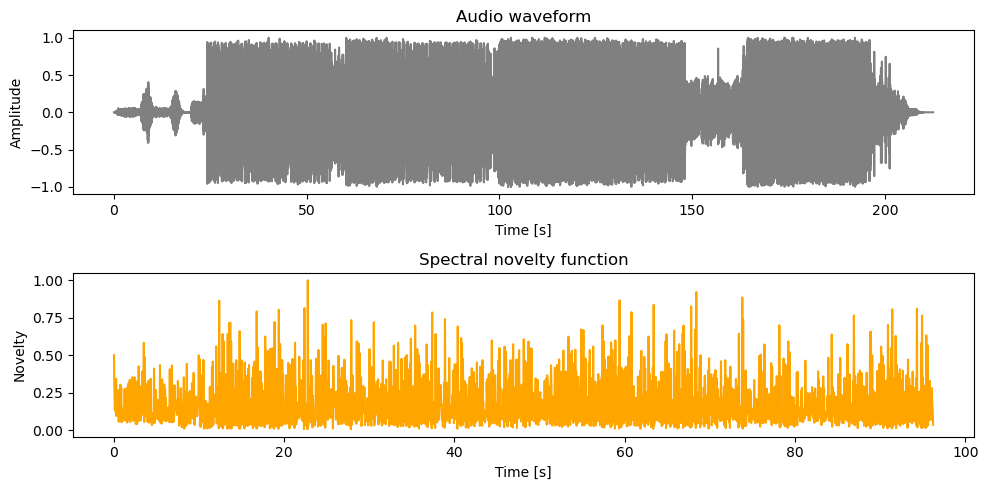

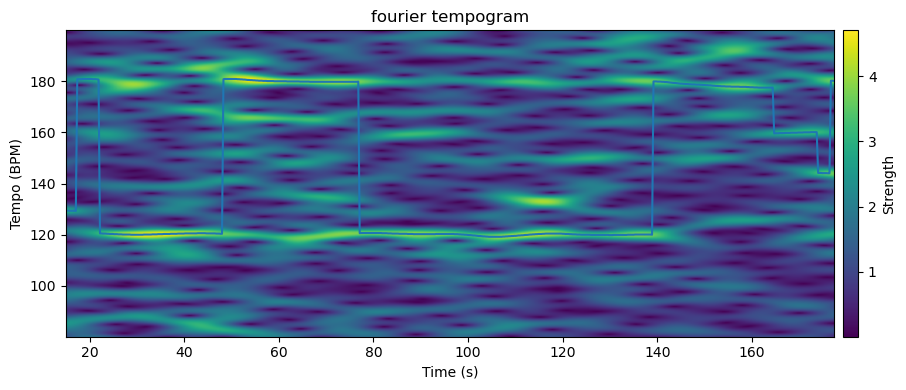

121.04554988946946

In [3]:
s1 = sound_C("/Users/jarlstephansson/Desktop/DT2470 Music/Project/data/KEY-BPM_train-val/20.mp3")


energy = BPM_extractor(s1.fs, novelty="spectral", tempogram="fourier", tempo_w=30, tempo_hop=0.3, novelty_w = 20.0, novelty_hop= 0.1)

energy.get_BPM(s1.sound, plot=True)


In [4]:
map_path = "../data/map.csv"
data_path = "../data/KEY-BPM_train-val"


def loop(map_path, data_path, novelty, tempogram): 
    df = pd.read_csv(map_path)
    errors = []
    key_preds = []
    bpms = []

    for i, row in df.iterrows():
        file_path = os.path.join(data_path, f"{row['nr']}.mp3")
        sound = sound_C(file_path)
        sr, audio = sound.fs, sound.sound

        Extractor = BPM_extractor(
            sr,
            novelty=novelty,
            tempogram=tempogram,
            tempo_w=30, tempo_hop=3, novelty_w = 5.0, novelty_hop= 0.05 #0.3 is max, wonder why 
        )
        bpm = Extractor.get_BPM(audio, plot=False)
        mse = np.abs(row["BPM"] - bpm) 
        errors.append(mse)
        bpms.append(bpm)
        # oskars 
        pred=predict_key(file_path)
        key_preds.append(pred)

    return bpms, key_preds
bpms, keys_preds=loop(map_path, data_path, "spectral", "fourier")



[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


In [5]:
df1 = pd.read_csv(map_path)
df1["predicted_BPM"] = bpms
df1["predicted_key"] = keys_preds

df1.head(50)

,nr,name,BPM,key,genre,predicted_BPM,predicted_key
0,1,alleswirdgut - Brutalismus 3000,150,4A,Techno,150.793457,4A
1,2,Drugs From Amsterdam - Mau P,125,2A,Techno,123.751658,5B
2,3,eat horsegiirL,180,7A,Techno,180.204133,10B
3,4,Hot&perfecT - Six Sex,156,1A,Techno,155.156250,6A
4,5,Babushka - Indecorum,150,11A,Techno,151.254956,11A
5,6,La Batteria - DJ Gigola,150,1A,Techno,146.788908,8A
6,7,Fred again.. - Danielle (Smile on My Face),130,7B,Dance,130.057617,7B
7,8,Barry Can’t Swim - Can We Still Be Friends (w...,128,7A,Dance,128.105469,7A
8,9,Swimming Paul - Fading,128,11A,Dance,128.635817,11A
9,10,Jorja Smith - Little Things x Gypsy Woman,127,1A,Dance,187.559509,1A


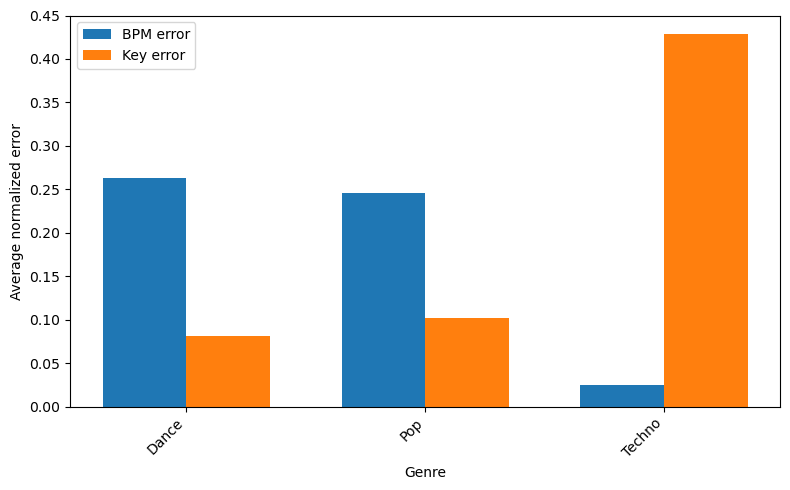

In [12]:
# For visualizing the errors: 
import math

def calc_key_diff(truth, pred):  
    truth = truth.strip(); pred = pred.strip()
    nr_t, let_t = int(truth[:-1]), truth[-1]
    nr_p, let_p = int(pred[:-1]), pred[-1]
    
    nr_diff = abs(nr_t - nr_p)
    nr_diff = min(nr_diff, 12 - nr_diff)  # circular distance
    
    let_diff = 0 if let_t == let_p else 1
    return (nr_diff + let_diff) / 7



def calc_bpm_diff(truth, pred):
    t, p = float(truth), float(pred)
    if t <= 0 or p <= 0:
        return 0.0
    d = abs(math.log2(p / t)) % 1.0   # wrap by octaves
    d = min(d, 1.0 - d)               # fold to [0, 0.5]
    return 1- (1.0 - 2.0 * d)              # score in [0,1]; 1 = perfect/octave

def visualize(df):
    bpm_e = []
    key_e = []
    for i, row in df.iterrows():
        bpm_t = row["BPM"]; bpm_p = row["predicted_BPM"] 
        key_t = row["key"]; key_p = row["predicted_key"]
        bpm_e.append(calc_bpm_diff(bpm_t, bpm_p))
        key_e.append(calc_key_diff(key_t, key_p))

    df["bpm_dist"] = bpm_e ; df["key_dist"] = key_e

    avg = df.groupby("genre")[["bpm_dist", "key_dist"]].mean().reset_index()

    x = np.arange(len(avg))
    width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, avg["bpm_dist"], width, label="BPM error")
    plt.bar(x + width/2, avg["key_dist"], width, label="Key error")

    plt.xticks(x, avg["genre"], rotation=45, ha="right")
    plt.ylabel("Average normalized error")
    plt.xlabel("Genre")
    plt.legend()
    plt.tight_layout()
    plt.show()
visualize(df1)

In [13]:
df1.head(1000)

,nr,name,BPM,key,genre,predicted_BPM,predicted_key,bpm_dist,key_dist
0,1,alleswirdgut - Brutalismus 3000,150,4A,Techno,150.793457,4A,0.015223,0.000000
1,2,Drugs From Amsterdam - Mau P,125,2A,Techno,123.751658,5B,0.028960,0.571429
2,3,eat horsegiirL,180,7A,Techno,180.204133,10B,0.003270,0.571429
3,4,Hot&perfecT - Six Sex,156,1A,Techno,155.156250,6A,0.015648,0.714286
4,5,Babushka - Indecorum,150,11A,Techno,151.254956,11A,0.024040,0.000000
5,6,La Batteria - DJ Gigola,150,1A,Techno,146.788908,8A,0.062439,0.714286
6,7,Fred again.. - Danielle (Smile on My Face),130,7B,Dance,130.057617,7B,0.001279,0.000000
7,8,Barry Can’t Swim - Can We Still Be Friends (w...,128,7A,Dance,128.105469,7A,0.002377,0.000000
8,9,Swimming Paul - Fading,128,11A,Dance,128.635817,11A,0.014297,0.000000
9,10,Jorja Smith - Little Things x Gypsy Woman,127,1A,Dance,187.559509,1A,0.874960,0.000000
